In [1]:
!python -m pip -q install pandas openpyxl matplotlib

In [2]:
import pandas as pd
import numpy as np

Laden der Excel

In [3]:
df = pd.read_excel("data/Biertoto.xlsx")

alles was im 'Heim' einen leeren String oder keinen Wert hat, entfernen

In [4]:
df = df.dropna(subset=['Heim']).copy()

Function um spaeter zu speichern ob ein Ergebnis Heimsieg, Auswaertssieg oder Untentschieden ist

In [5]:
def home_draw_away_generic(home_goals, away_goals)->str:
    """
    A = away team won
    H = home team won
    D = draw
    """
    diff = home_goals - away_goals
    if pd.isnull(home_goals) or pd.isnull(away_goals):
        return np.nan
    if diff < 0:
        return 'A'
    elif diff > 0:
        return 'H'
    else:
        return 'D'


Fuer das Spielergebnis berechnen od Heim- oder Auswaertssieg oder Untenschieden

In [6]:
def home_draw_away(row):
    return home_draw_away_generic(row['Htore'], row['Gtore'])
    

Fuer das Uwe-Tipp berechnen od Heim- oder Auswaertssieg oder Untenschieden

In [7]:
def home_draw_away_uwe(row):
    return home_draw_away_generic(row['UHT'], row['UGT'])

Fuer das Schadix-Tipp berechnen od Heim- oder Auswaertssieg oder Untenschieden

In [8]:
def home_draw_away_schadix(row):
    return home_draw_away_generic(row['SHT'], row['SGT'])

Funktion um zu checken ob 2 Ergebnisse identisch sind

In [9]:
def match_result_generic(home_goals_1, away_goals_1, home_goals_2, away_goals_2)->bool:
    if pd.isnull(home_goals_1) or pd.isnull(away_goals_1) or pd.isnull(home_goals_2) or pd.isnull(away_goals_2):
        return False
    try:
        return int(home_goals_1) == int(home_goals_2) and int(away_goals_1) == int(away_goals_2)
    except ValueError:
        return False

    

Funktion um zu checken ob 2 Ergebnisse die gleiche Tordifferenz haben

In [10]:
def same_goal_difference(home_goals_1, away_goals_1, home_goals_2, away_goals_2)->bool:
    if pd.isnull(home_goals_1) or pd.isnull(away_goals_1) or pd.isnull(home_goals_2) or pd.isnull(away_goals_2):
        return False
    try:
        return int(home_goals_1) - int(away_goals_1) == int(home_goals_2) - int(away_goals_2)
    except ValueError:
        return False

    

Funktion checkt ob Uwe die gleiche Tordifferenz hat wie das Spielergebnis

In [11]:
def same_goal_difference_uwe(row)->bool:
    return same_goal_difference(home_goals_1=row['UHT'], 
                                  away_goals_1=row['UGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Funktion checkt ob Schadix die gleiche Tordifferenz hat wie das Spielergebnis

In [12]:
def same_goal_difference_schadix(row)->bool:
    return same_goal_difference(home_goals_1=row['SHT'], 
                                  away_goals_1=row['SGT'],
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Funktion checkt ob Uwe das gleiche Ergebnis getippt hat wie das Spielergebnis

In [13]:
def same_result_uwe(row)->bool:
    return match_result_generic(home_goals_1=row['UHT'], 
                                  away_goals_1=row['UGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Funktion checkt ob Schadix das gleiche Ergebnis getippt hat wie das Spielergebnis

In [14]:
def same_result_schadix(row)->bool:
    return match_result_generic(home_goals_1=row['SHT'], 
                                  away_goals_1=row['SGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Fuer die Berechnungen und vor allem die Sortierung der Ergebnisse ist es einfacher wenn die Jahrezahlen komplett sind, also basteln wir das mal

In [15]:
def get_year(row)->int:
    """add 19 to string with split on / in case of 9x else add 20"""
    saison = row['Saison']
    first_year, second_year = saison.split('/')
    first_year = first_year.strip()
    if first_year.startswith('9'):
        return int("19"+first_year)
    else:
        return int("20"+first_year)
        

Punkte berechnen basierend auf der Biertoto Berechnung

In [16]:
def calculate_points_generic_historic(tendency:bool=False, 
                             same_goal_difference:bool=False, 
                             same_result:bool=False,
                            draw:bool=False)->int:
    result_points = 0
    if tendency:
        result_points += 1
    if same_goal_difference and not draw:
        result_points += 1
    if same_result:
        if not draw:
            result_points += 1
        else:
            result_points += 2
    return result_points
    

ein paar Tests

In [17]:
# Test historic calculation
assert calculate_points_generic_historic(tendency=True, same_goal_difference=True, same_result=False, draw=True) == 1 
assert calculate_points_generic_historic(tendency=True, same_goal_difference=True, same_result=True, draw=True) == 3 
assert calculate_points_generic_historic(tendency=False, same_goal_difference=False, same_result=False, draw=True) == 0
assert calculate_points_generic_historic(tendency=True, same_goal_difference=True, same_result=False, draw=False) == 2

Punkte berechnen basierend auf der Kicktipp Berechnung

In [18]:
def calculate_points_generic_kicktipp(tendency:bool=False, 
                             same_goal_difference:bool=False, 
                             same_result:bool=False,
                            draw:bool=False)->int:
    result_points = 0
    if tendency:
        result_points += 2
    if same_goal_difference and not draw:
        result_points += 1
    if same_result:
        if not draw:
            result_points += 1
        else:
            result_points += 1
    return result_points
    

und die ganzen Funktionen ausfuehren und als Columns in dem DataFrame speichern

In [19]:
df['year'] = df.apply(get_year, axis=1)

In [20]:
df['tendenz'] = df.apply(home_draw_away, axis=1)

In [21]:
df['tendenz_uwe'] = df.apply(home_draw_away_uwe, axis=1)

In [22]:
df['tendenz_schadix'] = df.apply(home_draw_away_schadix, axis=1)

In [23]:
df['correct_tendenz_uwe'] = df['tendenz'] == df['tendenz_uwe']

In [24]:
df['correct_tendenz_schadix'] = df['tendenz'] == df['tendenz_schadix']

In [25]:
df['same_goal_uwe'] = df.apply(same_goal_difference_uwe, axis=1)

In [26]:
df['same_goal_schadix'] = df.apply(same_goal_difference_schadix, axis=1)

In [27]:
df['same_result_uwe'] = df.apply(same_result_uwe, axis=1)

In [28]:
df['same_result_schadix'] = df.apply(same_result_schadix, axis=1)

In [29]:
df['result_match_uwe_schadix'] = df.apply(lambda row: match_result_generic(row['UHT'], row['UGT'], row['SHT'], row['SGT']), axis=1)

In [30]:
df['points_uwe'] = df.apply(lambda row: calculate_points_generic_kicktipp(tendency=row['tendenz_uwe']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_uwe'],
                                                                 same_result=row['same_result_uwe'],
                                                                 draw=row['SHT']==row['SGT']
                                                                ), axis=1)

In [31]:
df['points_uwe_historic'] = df.apply(lambda row: calculate_points_generic_historic(tendency=row['tendenz_uwe']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_uwe'],
                                                                 same_result=row['same_result_uwe'],
                                                                 draw=row['SHT']==row['SGT']
                                                                ), axis=1)

In [32]:
df['points_schadix'] = df.apply(lambda row: calculate_points_generic_kicktipp(tendency=row['tendenz_schadix']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_schadix'],
                                                                 same_result=row['same_result_schadix'],
                                                                 draw=row['SHT']==row['SGT']
                                                                ), axis=1)

In [33]:
df['points_schadix_historic'] = df.apply(lambda row: calculate_points_generic_historic(tendency=row['tendenz_schadix']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_schadix'],
                                                                 same_result=row['same_result_schadix'],
                                                                 draw=row['SHT']==row['SGT']                                                                                       
                                                                ), axis=1)

Einen String vom Ergebnis erzeugen um spaeter darueber Statistiken zu fahren, machen wir dann fuer das eigentliche Ergebnis, fuer das von Uwe und Schadix

In [34]:
def create_result_string(home_goals, guest_goals):
    if pd.isnull(home_goals) or pd.isnull(guest_goals):
        return np.nan
    else:
        return str(int(home_goals))+":"+str(int(guest_goals))
    

In [35]:
df['result_string']=df.apply(lambda row:str(int(row['Htore']))+":"+str(int(row['Gtore'])), axis=1)

In [36]:
df['result_string_uwe']=df.apply(lambda row: create_result_string(row['UHT'], row['UGT']), axis=1)

In [37]:
df['result_string_schadix']=df.apply(lambda row: create_result_string(row['SHT'], row['SGT']), axis=1)

Einmal alle column-namen ausgeben, nur mal so

In [38]:
df.columns

Index(['Heim', 'Gast', 'Htore', 'Gtore', 'UHT', 'UGT', 'SHT', 'SGT',
       'Spieltag', 'Saison', 'Unnamed: 10', 'UP', 'SP', 'Spieltag.1',
       'Unnamed: 14', 'year', 'tendenz', 'tendenz_uwe', 'tendenz_schadix',
       'correct_tendenz_uwe', 'correct_tendenz_schadix', 'same_goal_uwe',
       'same_goal_schadix', 'same_result_uwe', 'same_result_schadix',
       'result_match_uwe_schadix', 'points_uwe', 'points_uwe_historic',
       'points_schadix', 'points_schadix_historic', 'result_string',
       'result_string_uwe', 'result_string_schadix'],
      dtype='object')

Wie haeufig hat Schadix nicht getipp?

In [39]:
df[df['SHT'].isna()]

,Heim,Gast,Htore,Gtore,UHT,UGT,SHT,SGT,Spieltag,Saison,...,same_result_uwe,same_result_schadix,result_match_uwe_schadix,points_uwe,points_uwe_historic,points_schadix,points_schadix_historic,result_string,result_string_uwe,result_string_schadix
1620,Energie Cottbus,Vfl Wolfsburg,0.0,0.0,3.0,1.0,NaN,NaN,28,00/01,...,False,False,False,0,0,0,0,0:0,3:1,NaN
1621,Eintracht Frankfurt,Bayer Leverkusen,1.0,3.0,0.0,3.0,NaN,NaN,28,00/01,...,False,False,False,2,1,0,0,1:3,0:3,NaN
1622,1. FC Köln,SpVgg Unterhaching,1.0,1.0,4.0,1.0,NaN,NaN,28,00/01,...,False,False,False,0,0,0,0,1:1,4:1,NaN
1623,1860 München,Vfl Bochum,2.0,4.0,3.0,0.0,NaN,NaN,28,00/01,...,False,False,False,0,0,0,0,2:4,3:0,NaN
1624,Werder Bremen,Hertha BSC Berlin,3.0,1.0,2.0,0.0,NaN,NaN,28,00/01,...,False,False,False,3,2,0,0,3:1,2:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7191,FC Bayern München,Hertha BSC,2.0,2.0,2.0,0.0,NaN,NaN,1,19/20,...,False,False,False,0,0,0,0,2:2,2:0,NaN
7758,1. FC Köln,RB Leipzig,2.0,1.0,1.0,3.0,NaN,NaN,30,20/21,...,False,False,False,0,0,0,0,2:1,1:3,NaN
7759,FC Bayern München,Bayer 04 Leverkusen,2.0,0.0,3.0,1.0,NaN,NaN,30,20/21,...,False,False,False,3,2,0,0,2:0,3:1,NaN
7760,Eintracht Frankfurt,FC Augsburg,2.0,0.0,2.0,1.0,NaN,NaN,30,20/21,...,False,False,False,2,1,0,0,2:0,2:1,NaN


Gruppiere in Jahre und summiere die Punkte fuer Uwe und Schadix auf und speichere in einen neuen DataFrame

## Kicktipp Calculation

In [40]:
df_points_sum = df.groupby('year').sum(['points_schadix', 'points_uwe'])[['points_schadix', 'points_uwe']]

In [41]:
df_points_sum

,points_schadix,points_uwe
year,,
1995,124,141
1996,345,367
1997,316,348
1998,321,383
1999,353,362
2000,296,366
2001,327,382
2002,311,360
2003,407,355


### Gesamtpunkte im Laufe der Zeit

Jetzt mal die kummulierten Punkte in einer Grafik darstellen

In [42]:
df_sum_points = df_points_sum.cumsum()

<AxesSubplot:xlabel='year'>

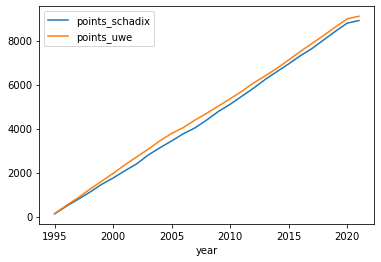

In [43]:
df_points_sum.cumsum().plot()

### Gesamtpunke-Abstand Uwe-Schadix

<AxesSubplot:xlabel='year'>

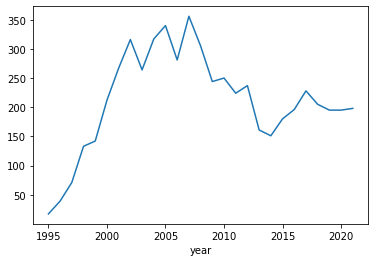

In [44]:
df_sum_points['point_difference'] = df_sum_points['points_uwe'] - df_sum_points['points_schadix']
df_sum_points['point_difference'].plot()

## Historische Kalkulation

In [45]:
df_points_sum = df.groupby('year').sum(['points_schadix_historic', 'points_uwe_historic'])[['points_schadix_historic', 'points_uwe_historic']]

In [46]:
df_points_sum

,points_schadix_historic,points_uwe_historic
year,,
1995,72,85
1996,205,222
1997,197,217
1998,196,237
1999,222,219
2000,177,219
2001,192,226
2002,187,220
2003,250,211


### Gesamtpunkte im Laufe der Zeit

Jetzt mal die kummulierten Punkte in einer Grafik darstellen

In [47]:
df_sum_points = df_points_sum.cumsum()

<AxesSubplot:xlabel='year'>

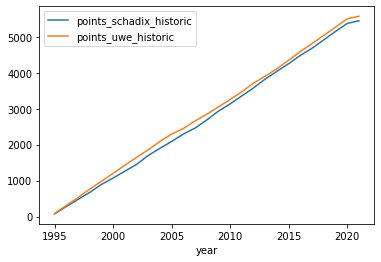

In [48]:
df_points_sum.cumsum().plot()

### Gesamtpunke-Abstand Uwe-Schadix

<AxesSubplot:xlabel='year'>

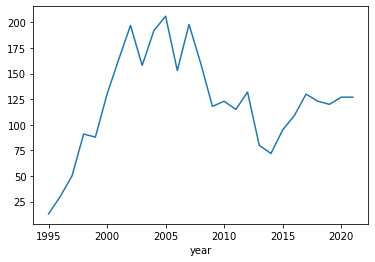

In [49]:
df_sum_points['point_difference'] = df_sum_points['points_uwe_historic'] - df_sum_points['points_schadix_historic']
df_sum_points['point_difference'].plot()

### Wie haeufig gleiche Ergebnisse getippt im Laufe der Zeit

Das [:1] am Ende nimmt die aktuelle Saison raus, weil da noch nicht so viele Ergebnisse vorhanden sind und die Statistik dann nach unten gerissen wird. 

In [50]:
df_same_tipps_over_time = df.groupby('year').sum(['result_match_uwe_schadix'])[['result_match_uwe_schadix']][:-1]

damits nicht so eckig aussieht, machen wir ein smoothing des graphen ueber die mean letzten 10 Ergenisse 

In [51]:
df_same_tipps_over_time['avg_10'] = df_same_tipps_over_time.result_match_uwe_schadix.rolling(10, min_periods=0).mean()

<AxesSubplot:xlabel='year'>

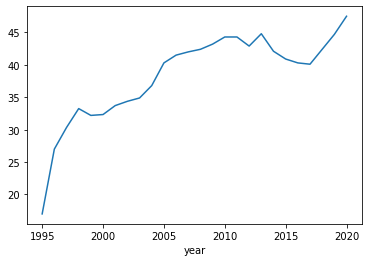

In [52]:
df_same_tipps_over_time['avg_10'].plot()

Wie haeufig haben wir die gleiche Tendenz getipp im Laufe der Zeit?

In [53]:
df['same_tendenz_uwe_schadix'] = df.apply(lambda row: row['tendenz_uwe'] == row['tendenz_schadix'], axis=1)

In [54]:
df_same_tendenz_uwe_schadix = df.groupby('year').sum(['same_tendenz_uwe_schadix'])[['same_tendenz_uwe_schadix']][:-1]

damits nicht so eckig aussieht, machen wir ein smoothing des graphen ueber die mean letzten 10 Ergenisse 

In [55]:
df_same_tendenz_uwe_schadix['avg_10'] = df_same_tendenz_uwe_schadix.same_tendenz_uwe_schadix.rolling(10, min_periods=0).mean()

<AxesSubplot:xlabel='year'>

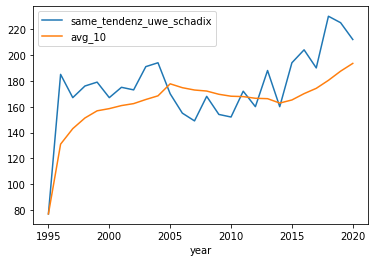

In [56]:
df_same_tendenz_uwe_schadix.plot()

Probability of results

In [57]:
results_count = df.groupby('result_string')['result_string'].count().sort_values()
results_sum = results_count.sum()
df_results_count = pd.DataFrame(index=results_count.index, data=results_count.values, columns=['count'])
# results_count['probability_result'] = results_count['']
df_results_count['probability_result'] = df_results_count['count'] / results_sum

### Wahrscheinlichkeit fuer ein 0:0

In [58]:
zero_draw_probability = float(df_results_count[df_results_count.index == '0:0']['probability_result'])
print(f"Wahrscheinlichkeit fuer ein 0:0 = {zero_draw_probability*100:0.2f} %")

Wahrscheinlichkeit fuer ein 0:0 = 6.71 %


### Es gab in den letzten 25 Jahren kein 5:5...

In [59]:
a = df_results_count[df_results_count.index == '5:5']['probability_result']
len(a)

0

In [60]:
def get_probability_number(result_string):
    # print(result_string)
    if pd.isnull(result_string):
        return np.nan
    try:
        prob = df_results_count[df_results_count.index == result_string]['probability_result']
        if len(prob) == 0:
            return 1
        return 1 - float(prob)
    except KeyError as ke:
        return np.nan


In [61]:
df['probability_count_uwe'] = df.apply(lambda row:get_probability_number(row['result_string_uwe']), axis=1)

In [62]:
df['probability_count_schadix'] = df.apply(lambda row:get_probability_number(row['result_string_schadix']), axis=1)

In [63]:
print(f"Uwe: {df['probability_count_uwe'].sum()}")
print(f"Schadix: {df['probability_count_schadix'].sum()}")

Uwe: 7331.625364246801
Schadix: 7170.185100722159


Probability of results with tips combined

Mit welchem Ergebnis haben wir die meisten Punkte gesammelt

In [64]:
df.groupby("result_string_schadix")['points_schadix'].sum(['points_schadix']).sort_values(ascending=False)

result_string_schadix
2:0    1628
2:1    1379
1:0    1195
3:1     892
3:0     590
1:1     573
0:2     571
1:2     449
0:1     419
1:3     262
2:2     203
0:3     196
3:2     137
4:0      87
0:0      85
4:1      61
2:3      58
0:4      38
1:4      20
5:1      15
4:2      10
3:3       8
4:3       8
1:5       6
5:0       4
2:4       4
6:1       3
1:8       2
0:5       2
6:2       2
3:5       0
3:4       0
5:5       0
6:0       0
Name: points_schadix, dtype: int64

In [65]:
df.groupby("result_string_uwe")['points_uwe'].sum(['points_uwe']).sort_values(ascending=False)

result_string_uwe
2:0    1556
2:1    1552
3:1    1104
1:1     821
3:0     737
1:2     686
1:3     616
0:2     556
1:0     537
2:2     240
0:3     165
0:1     136
4:0     107
0:0      84
4:1      83
3:2      39
1:4      38
0:4      20
4:2      16
2:4       6
2:3       4
0:5       2
1:5       0
5:0       0
5:1       0
5:2       0
5:4       0
Name: points_uwe, dtype: int64

#### max points spieltag

In [66]:
df_points_spieltag = df.groupby(['year', 'Spieltag']).sum(['points_uwe', 'points_schadix'])

In [67]:
df_points_spieltag

Htore  Gtore   UHT   UGT   SHT   SGT  Unnamed: 10    UP    SP  \
year Spieltag                                                                  
1995 18         12.0    8.0  11.0  15.0   9.0  12.0         45.0   3.0   3.0   
     19         11.0   12.0  20.0   4.0  14.0   9.0        126.0   5.0   2.0   
     20         10.0   11.0  14.0  14.0  14.0   5.0        207.0   4.0   3.0   
     21         14.0    7.0  16.0   5.0  11.0  11.0        288.0   6.0  10.0   
     22         14.0    8.0  15.0   8.0  17.0   8.0        369.0   6.0   5.0   
...              ...    ...   ...   ...   ...   ...          ...   ...   ...   
2021 6          17.0    5.0  13.0  14.0  13.0  11.0      70677.0   6.0   6.0   
     7          15.0   16.0  18.0  12.0  17.0   9.0      70758.0   5.0   5.0   
     8          15.0   12.0  15.0   8.0  17.0   8.0      70839.0   5.0   4.0   
     9          19.0   10.0  15.0  14.0  13.0  11.0      70920.0   7.0   9.0   
     10         17.0   13.0  17.0  11.0  14.0  12.0      71001.0  11.0  16.0   

               Spieltag.1  ...  same_result_uwe  same_result_schadix  \
year Spieltag              ...                                         
1995 18               3.0  ...                0                    0   
     19               5.0  ...                1                    0   
     20               4.0  ...                1                    1   
     21               6.0  ...                0                    2   
     22               6.0  ...                0                    0   
...                   ...  ...              ...                  ...   
2021 6                6.0  ...                0                    0   
     7                5.0  ...                0                    0   
     8                5.0  ...                1                    1   
     9                7.0  ...                1                    2   
     10              11.0  ...                1                    4   

               result_match_uwe_schadix  points_uwe  points_uwe_historic  \
year Spieltag                                                              
1995 18                               2           5                    3   
     19                               0           8                    5   
     20                               1           6                    4   
     21                               1          11                    6   
     22                               3          11                    7   
...                                 ...         ...                  ...   
2021 6                                2          11                    6   
     7                                4           9                    5   
     8                                0           8                    5   
     9                                4          11                    7   
     10                               2          17                   11   

               points_schadix  points_schadix_historic  \
year Spieltag                                            
1995 18                     6                        3   
     19                     4                        2   
     20                     4                        3   
     21                    15                       10   
     22                     9                        5   
...                       ...                      ...   
2021 6                     11                        6   
     7                      9                        5   
     8                      6                        4   
     9                     13                        9   
     10                    22                       16   

               same_tendenz_uwe_schadix  probability_count_uwe  \
year Spieltag                                                    
1995 18                               6               8.450652   
     19                               5               8.327885   
     20                      

In [68]:
df_points_spieltag.columns

Index(['Htore', 'Gtore', 'UHT', 'UGT', 'SHT', 'SGT', 'Unnamed: 10', 'UP', 'SP',
       'Spieltag.1', 'Unnamed: 14', 'correct_tendenz_uwe',
       'correct_tendenz_schadix', 'same_goal_uwe', 'same_goal_schadix',
       'same_result_uwe', 'same_result_schadix', 'result_match_uwe_schadix',
       'points_uwe', 'points_uwe_historic', 'points_schadix',
       'points_schadix_historic', 'same_tendenz_uwe_schadix',
       'probability_count_uwe', 'probability_count_schadix'],
      dtype='object')

## Schadix Spieltag mit den meisten Punkten

In [96]:
df_points_spieltag[df_points_spieltag['points_schadix'] == df_points_spieltag['points_schadix'].max()]['points_schadix']

year  Spieltag
2009  9           28
Name: points_schadix, dtype: int64

In [96]:
df_points_spieltag[df_points_spieltag['points_schadix'] == df_points_spieltag['points_schadix'].max()]['points_schadix']

year  Spieltag
2009  9           28
Name: points_schadix, dtype: int64

## Uwe Spieltag mit den meisten Punkten

In [95]:
df_points_spieltag[df_points_spieltag['points_uwe'] == df_points_spieltag['points_uwe'].max()]['points_uwe']

year  Spieltag
2000  2           23
2004  22          23
Name: points_uwe, dtype: int64

## Lucky? 

Wie hauefig einen Spieltag verloren selbst wenn mehr Tendenzen correct waren

In [74]:
df.columns

Index(['Heim', 'Gast', 'Htore', 'Gtore', 'UHT', 'UGT', 'SHT', 'SGT',
       'Spieltag', 'Saison', 'Unnamed: 10', 'UP', 'SP', 'Spieltag.1',
       'Unnamed: 14', 'year', 'tendenz', 'tendenz_uwe', 'tendenz_schadix',
       'correct_tendenz_uwe', 'correct_tendenz_schadix', 'same_goal_uwe',
       'same_goal_schadix', 'same_result_uwe', 'same_result_schadix',
       'result_match_uwe_schadix', 'points_uwe', 'points_uwe_historic',
       'points_schadix', 'points_schadix_historic', 'result_string',
       'result_string_uwe', 'result_string_schadix',
       'same_tendenz_uwe_schadix', 'probability_count_uwe',
       'probability_count_schadix'],
      dtype='object')

In [81]:
df_tendenz_points = df.groupby(['year', 'Spieltag']).sum(['correct_tendenz_uwe', 
                                                           'correct_tendenz_schadix', 
                                                           'points_uwe', 
                                                           'points_schadix'])

In [83]:
df_tendenz_points['correct_tendenz_uwe']

year  Spieltag
1995  18          2
      19          3
      20          2
      21          5
      22          4
                 ..
2021  6           5
      7           4
      8           3
      9           4
      10          6
Name: correct_tendenz_uwe, Length: 877, dtype: int64

In [93]:
df_tendenz_points[ (df_tendenz_points['correct_tendenz_uwe'] 
                    > df_tendenz_points['correct_tendenz_schadix']) & 
                  (df_tendenz_points['points_uwe'] 
                   < df_tendenz_points['points_schadix']) ][['correct_tendenz_uwe', 'correct_tendenz_schadix', 'points_uwe', 'points_schadix']]

correct_tendenz_uwe  correct_tendenz_schadix  points_uwe  \
year Spieltag                                                             
1997 33                          4                        3           8   
2002 21                          5                        4          10   
2003 12                          8                        7          16   
2011 21                          7                        6          15   
     25                          4                        3           9   
2014 33                          5                        4          11   
2015 6                           6                        5          14   

               points_schadix  
year Spieltag                  
1997 33                     9  
2002 21                    11  
2003 12                    17  
2011 21                    17  
     25                    10  
2014 33                    13  
2015 6                     15

In [94]:
df_tendenz_points[ (df_tendenz_points['correct_tendenz_schadix'] 
                    > df_tendenz_points['correct_tendenz_uwe']) & 
                  (df_tendenz_points['points_schadix'] 
                   < df_tendenz_points['points_uwe']) ][['correct_tendenz_uwe', 'correct_tendenz_schadix', 'points_uwe', 'points_schadix']]

,,correct_tendenz_uwe,correct_tendenz_schadix,points_uwe,points_schadix
year,Spieltag,,,,
1996,4,4,5,11,10
1998,8,5,6,13,12
2001,28,5,6,16,14
2004,33,3,4,9,8
2008,11,4,5,13,12
2010,27,5,6,16,14
2011,32,3,4,9,8
2012,5,4,5,12,10
2016,26,5,7,16,14


Wie haeufig vergessen zu tippen (gesamt und ueber zeit)

Mit welchen Mannschaften die meisten Punkte?

Gegen den Tabellenstand getippt? (Getippt dass die Mannschaft mit der hoeheren Tabellenposition-zahl gewinnt)

Spieltagsiege (insgesamt, ueber-Zeit)